In [1]:
import numpy as np
import warnings
from PIL import Image
import matplotlib
import matplotlib.pyplot as plt
import skimage.io as io
import skimage.filters as flt
%matplotlib inline
import scipy.ndimage.filters as flt

In [2]:

def anisodiff(img,niter=1,kappa=50,gamma=0.1,step=(1.,1.),option=1,ploton=False):
    
 
    # ...you could always diffuse each color channel independently if you
    # really want
    if img.ndim == 3:
        warnings.warn("Only grayscale images allowed, converting to 2D matrix")
        img = img.mean(2)
 
    # initialize output array
    img = img.astype('float32')
    imgout = img.copy()
 
    # initialize some internal variables
    deltaS = np.zeros_like(imgout)
    deltaE = deltaS.copy()
    NS = deltaS.copy()
    EW = deltaS.copy()
    gS = np.ones_like(imgout)
    gE = gS.copy()
 
    # create the plot figure, if requested
    if ploton:
        import pylab as pl
        from time import sleep
 
        fig = pl.figure(figsize=(20,5.5),num="Anisotropic diffusion")
        ax1,ax2 = fig.add_subplot(1,2,1),fig.add_subplot(1,2,2)
 
        ax1.imshow(img,interpolation='nearest')
        ih = ax2.imshow(imgout,interpolation='nearest',animated=True)
        ax1.set_title("Original image")
        ax2.set_title("Iteration 0")
 
        fig.canvas.draw()
 
    for ii in range(niter):
 
        # calculate the diffs
        deltaS[:-1,: ] = np.diff(imgout,axis=0)
        deltaE[: ,:-1] = np.diff(imgout,axis=1)
 
        # conduction gradients (only need to compute one per dim!)
        if option == 1:
            gS = np.exp(-(deltaS/kappa)**2.)/step[0]
            gE = np.exp(-(deltaE/kappa)**2.)/step[1]
        elif option == 2:
            gS = 1./(1.+(deltaS/kappa)**2.)/step[0]
            gE = 1./(1.+(deltaE/kappa)**2.)/step[1]
 
        # update matrices
        E = gE*deltaE
        S = gS*deltaS
 
        # subtract a copy that has been shifted 'North/West' by one
        # pixel. don't as questions. just do it. trust me.
        NS[:] = S
        EW[:] = E
        NS[1:,:] -= S[:-1,:]
        EW[:,1:] -= E[:,:-1]
 
        # update the image
        imgout += gamma*(NS+EW)
 
        if ploton:
            iterstring = "Iteration %i" %(ii+1)
            ih.set_data(imgout)
            ax2.set_title(iterstring)
            fig.canvas.draw()
            # sleep(0.01)
 
    return imgout
 
def anisodiff3(stack,niter=1,kappa=50,gamma=0.1,step=(1.,1.,1.),option=1,ploton=False):
 
    # ...you could always diffuse each color channel independently if you
    # really want
    if stack.ndim == 4:
        warnings.warn("Only grayscale stacks allowed, converting to 3D matrix")
        stack = stack.mean(3)
 
    # initialize output array
    stack = stack.astype('float32')
    stackout = stack.copy()
 
    # initialize some internal variables
    deltaS = np.zeros_like(stackout)
    deltaE = deltaS.copy()
    deltaD = deltaS.copy()
    NS = deltaS.copy()
    EW = deltaS.copy()
    UD = deltaS.copy()
    gS = np.ones_like(stackout)
    gE = gS.copy()
    gD = gS.copy()
 
    # create the plot figure, if requested
    if ploton:
        import pylab as pl
        from time import sleep
 
        showplane = stack.shape[0]//2
 
        fig = pl.figure(figsize=(20,5.5),num="Anisotropic diffusion")
        ax1,ax2 = fig.add_subplot(1,2,1),fig.add_subplot(1,2,2)
 
        ax1.imshow(stack[showplane,...].squeeze(),interpolation='nearest')
        ih = ax2.imshow(stackout[showplane,...].squeeze(),interpolation='nearest',animated=True)
        ax1.set_title("Original stack (Z = %i)" %showplane)
        ax2.set_title("Iteration 0")
 
        fig.canvas.draw()
 
    for ii in range(niter):
 
        # calculate the diffs
        deltaD[:-1,: ,:  ] = np.diff(stackout,axis=0)
        deltaS[:  ,:-1,: ] = np.diff(stackout,axis=1)
        deltaE[:  ,: ,:-1] = np.diff(stackout,axis=2)
 
        # conduction gradients (only need to compute one per dim!)
        if option == 1:
            gD = np.exp(-(deltaD/kappa)**2.)/step[0]
            gS = np.exp(-(deltaS/kappa)**2.)/step[1]
            gE = np.exp(-(deltaE/kappa)**2.)/step[2]
        elif option == 2:
            gD = 1./(1.+(deltaD/kappa)**2.)/step[0]
            gS = 1./(1.+(deltaS/kappa)**2.)/step[1]
            gE = 1./(1.+(deltaE/kappa)**2.)/step[2]
 
        # update matrices
        D = gD*deltaD
        E = gE*deltaE
        S = gS*deltaS
 
        # subtract a copy that has been shifted 'Up/North/West' by one pixel
        UD[:] = D
        NS[:] = S
        EW[:] = E
        UD[1:,: ,: ] -= D[:-1,:  ,:  ]
        NS[: ,1:,: ] -= S[:  ,:-1,:  ]
        EW[: ,: ,1:] -= E[:  ,:  ,:-1]
 
        # update the image
        stackout += gamma*(UD+NS+EW)
 
        if ploton:
            iterstring = "Iteration %i" %(ii+1)
            ih.set_data(stackout[showplane,...].squeeze())
            ax2.set_title(iterstring)
            fig.canvas.draw()
            # sleep(0.01)
 
    return stackout

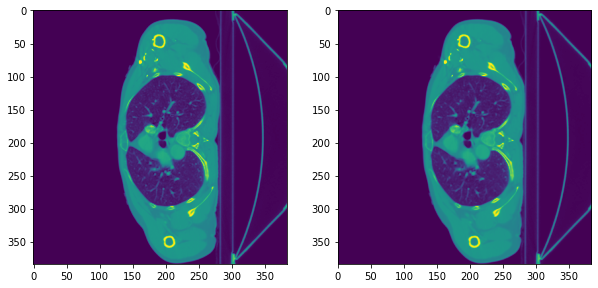

In [3]:
im = np.array(Image.open(r'Dataset-Train-updated\0522c0001\image-000.png'))
fim1=anisodiff(im)

plt.figure(figsize=(10,6))
plt.subplot(121)
plt.imshow(im)

plt.subplot(122)
plt.imshow(fim1)

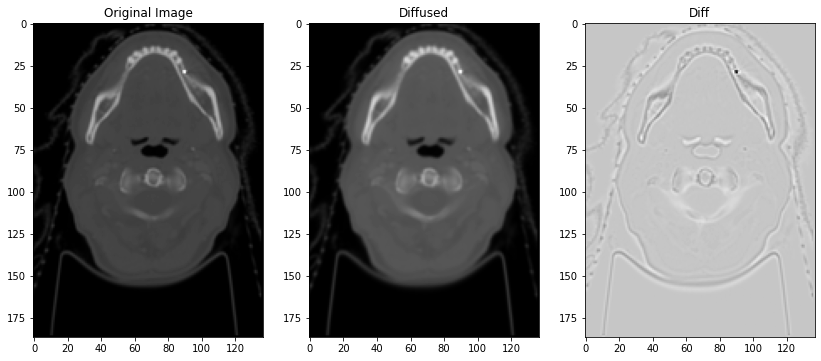

In [5]:
#im3=io.imread('img.nrrd')
im3= np.load('img_crp_v2.npy')
fimg=anisodiff3(im3)

plt.figure(figsize=(14,6))
plt.subplot(131)
plt.title('Original Image')
plt.imshow(im3[22],cmap='gray')

plt.subplot(132)
plt.title('Diffused')
plt.imshow(fimg[22],cmap='gray')

dimg=fimg-im3
plt.subplot(133)
plt.title('Diff')
plt.imshow(dimg[22],cmap='gray')

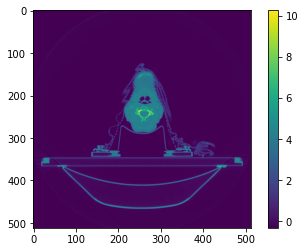

In [51]:
#im3=io.imread('img.nrrd')
img=io.imread('img.nrrd')
img=img.astype(float)
img=img[53]
m=np.mean(img)
s=np.std(img)
nimg=(img-m)/s
plt.imshow(nimg)
plt.colorbar()

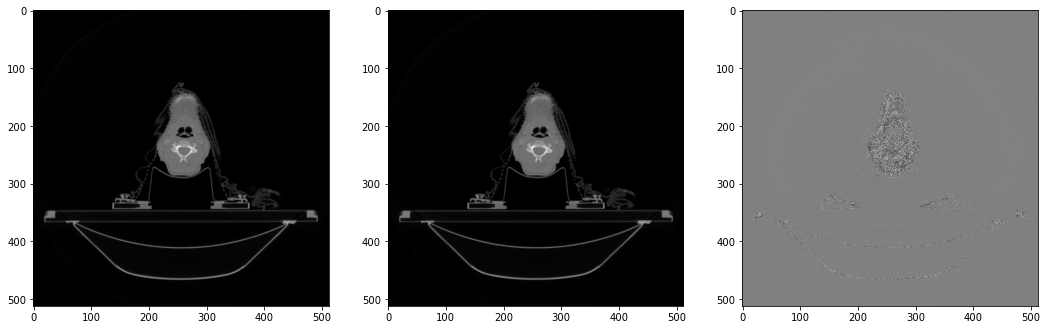

In [52]:
fimg3=anisodiff3(nimg)
plt.figure(figsize=(18,6))
plt.subplot(131)
plt.imshow(nimg,cmap='gray')

plt.subplot(132)
plt.imshow(fimg3,cmap='gray')

plt.subplot(133)
plt.imshow(fimg3-nimg,cmap='gray')